<a href="https://colab.research.google.com/github/1211307539/Flower-Classification/blob/testing/flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from collections import Counter
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import time


In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [4]:
## get dataset (using github)

# !git clone https://github.com/1211307539/Flower-Classification.git
# dataset_path = pathlib.Path("Flower-Classification/flowers")
# classes = os.listdir(dataset_path)


In [ ]:
# Dataset Path
# dataset_path = pathlib.Path("../previous project/flowers")
dataset_path = pathlib.Path("flowers")

# Classes is a list with the names of the Dataset folders (which are the classes)
classes = os.listdir(dataset_path)

In [5]:
data = []
images_list = []
labels_list = []

In [6]:
# Loop through the folders of the main dataset
for folder in classes:
    folder_path = dataset_path / folder
    for image in sorted(os.listdir(folder_path)):
        image_path = folder_path / image
        data.append((image_path, image, folder, classes.index(folder)))

# Create DataFrame with the data from the list data
df = pd.DataFrame(data, columns=['image_path', 'image_name', 'label_name', 'label_number'])
pd.set_option("display.max.columns", None)

In [ ]:
# Show the head of the DataFrame df
df.head(10)

,image_path,image_name,label_name,label_number
0,flowers\daisy\100080576_f52e8ee070_n.jpg,100080576_f52e8ee070_n.jpg,daisy,0
1,flowers\daisy\10140303196_b88d3d6cec.jpg,10140303196_b88d3d6cec.jpg,daisy,0
2,flowers\daisy\10172379554_b296050f82_n.jpg,10172379554_b296050f82_n.jpg,daisy,0
3,flowers\daisy\10172567486_2748826a8b.jpg,10172567486_2748826a8b.jpg,daisy,0
4,flowers\daisy\10172636503_21bededa75_n.jpg,10172636503_21bededa75_n.jpg,daisy,0
5,flowers\daisy\102841525_bd6628ae3c.jpg,102841525_bd6628ae3c.jpg,daisy,0
6,flowers\daisy\10300722094_28fa978807_n.jpg,10300722094_28fa978807_n.jpg,daisy,0
7,flowers\daisy\1031799732_e7f4008c03.jpg,1031799732_e7f4008c03.jpg,daisy,0
8,flowers\daisy\10391248763_1d16681106_n.jpg,10391248763_1d16681106_n.jpg,daisy,0
9,flowers\daisy\10437754174_22ec990b77_m.jpg,10437754174_22ec990b77_m.jpg,daisy,0


In [18]:
# Count the number of images in each class of the df
image_counts = df['label_name'].value_counts()

# Calculate mean, variance, and standard deviation
mean_count = np.mean(image_counts)
variance = np.var(image_counts, ddof=0)
std_deviation = np.sqrt(variance)

print(f"Mean:", mean_count)
print(f"Variance:", variance)
print(f"Standard Deviation:", std_deviation)

Mean: 863.4
Variance: 16660.64
Standard Deviation: 129.07610158352318


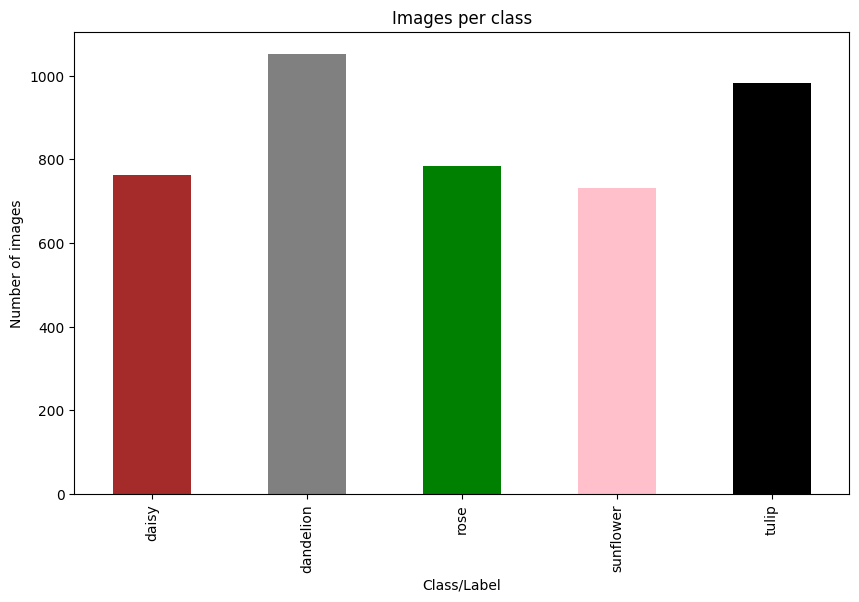

In [19]:
# Counts the occurrences of each unique value in the label_name column of the DataFrame
classes_toshow = df.label_name.value_counts().sort_index()
# Plot the classes and the number of images in each class
plt.figure(figsize = (10, 6))
classes_toshow.plot(kind='bar', color= ['brown', 'gray','green','pink','black'])

plt.title('Images per class')
plt.xlabel('Class/Label')
plt.ylabel('Number of images')
plt.show()

In [20]:
def plot_together(image_paths, title, image_num=15):
    # If the input image number is bigger than the dataset then the function stops
    if image_num > len(image_paths):
        print("Image number is bigger than the dataset!")
        return

    # Creates a 3x5 grid of subplots
    fig, axes = plt.subplots(3, 5, figsize=(15, 8))
    axes = axes.flatten()

    # For i=0 until i=image_number
    for i in range(image_num):
        # Take the image path
        img_path = image_paths[i]
        # Take the image using PIL
        img = Image.open(img_path)
        # Make subplot of the current image
        axes[i].imshow(img)
        axes[i].set_title(f"{title} {i+1}")
        axes[i].axis('off')

    # Show the whole plot with the subplots
    plt.show()

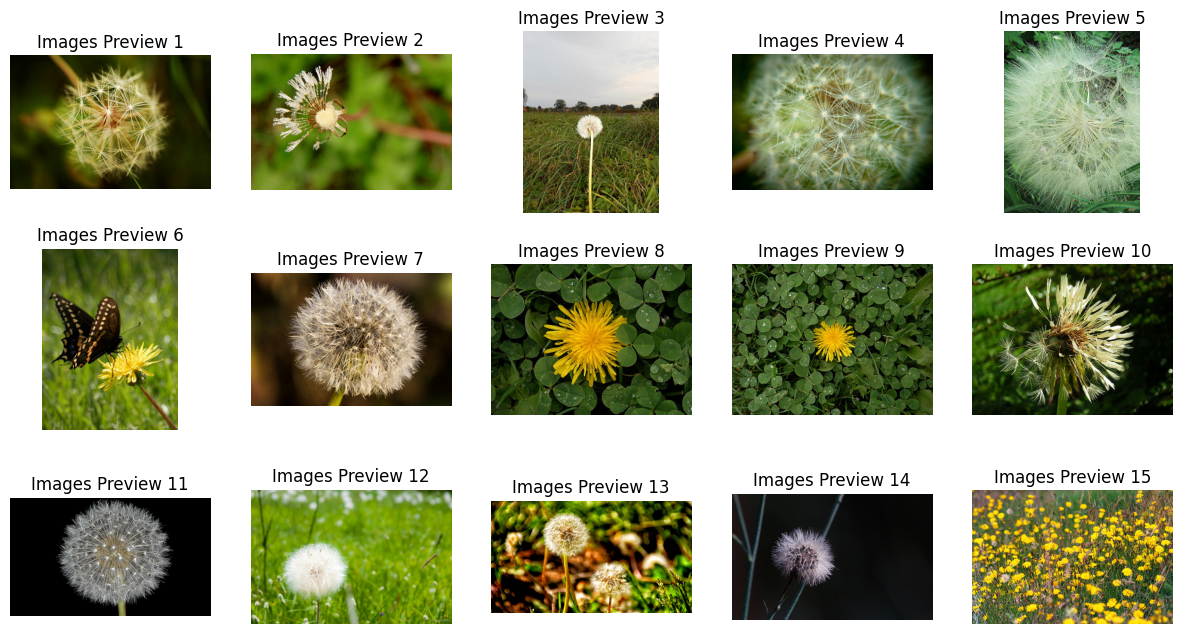

In [21]:
# Locate images with label 3 from the DataFrame
images_to_preview = df.loc[df['label_number']==3]['image_path'].values
# Call the function with our custom inputs
plot_together(images_to_preview, 'Images Preview')

In [7]:
#Encode the labels to numerical format
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label_name'])

In [8]:
# Extract image paths and labels
image_paths = df['image_path'].values
labels = df['encoded_label'].values

In [9]:
#Preprocess images (resize, flatten, normalize)
def preprocess_images(image_paths, target_size=(128, 128)):
    images = []
    for path in image_paths:
        img = Image.open(path).resize(target_size)
        img = np.array(img) / 255.0  # Normalize to [0, 1]
        images.append(img.flatten())  # Flatten the image
    return np.array(images)

X = preprocess_images(image_paths)
y = labels

In [10]:
#Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [11]:
#Shuffle the dataset after resampling
X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=42)

In [12]:
#Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

In [ ]:
#Display class distribution after SMOTE
class_counts_after_smote = Counter(y_resampled)
print("Class distribution after SMOTE:", class_counts_after_smote)

Class distribution after SMOTE: Counter({2: 1052, 4: 1052, 0: 1052, 3: 1052, 1: 1052})


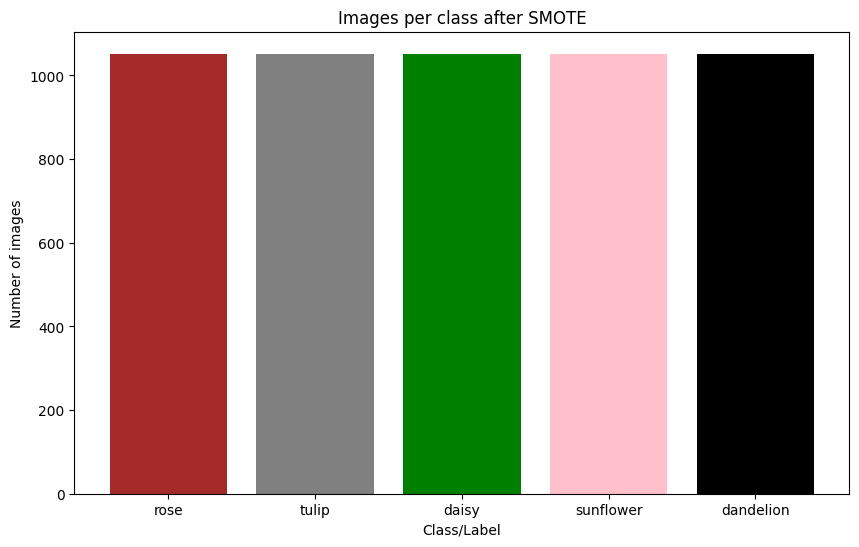

In [ ]:
# Plot the classes and the number of images in each class after SMOTE
labels_after_smote = [label_encoder.inverse_transform([key])[0] for key in class_counts_after_smote.keys()]
counts_after_smote = [class_counts_after_smote[key] for key in class_counts_after_smote.keys()]

plt.figure(figsize=(10, 6))
plt.bar(labels_after_smote, counts_after_smote, color=['brown', 'gray', 'green', 'pink', 'black'])
plt.title('Images per class after SMOTE')
plt.xlabel('Class/Label')
plt.ylabel('Number of images')
plt.show()

In [28]:
#Save the training and testing data for model usage
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 4208
Testing set size: 1052


## Neural Network

In [ ]:
# Reshape X_train and X_test to their original image dimensions
X_train = X_train.reshape(-1, 128, 128, 3)
X_test = X_test.reshape(-1, 128, 128, 3)

In [ ]:
# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
# Create the model
input_shape = (128, 128, 3)
num_classes = len(classes)
model = create_cnn_model(input_shape, num_classes)


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 307ms/step - accuracy: 0.9773 - loss: 0.0683 - val_accuracy: 0.7684 - val_loss: 1.6495
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 50s 474ms/step - accuracy: 0.9840 - loss: 0.0538 - val_accuracy: 0.7387 - val_loss: 1.6072
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 325ms/step - accuracy: 0.9686 - loss: 0.0778 - val_accuracy: 0.7637 - val_loss: 1.5326
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 38s 357ms/step - accuracy: 0.9775 - loss: 0.0604 - val_accuracy: 0.7542 - val_loss: 1.7014
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 37s 346ms/step - accuracy: 0.9833 - loss: 0.0581 - val_accuracy: 0.7613 - val_loss: 1.7744
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 36s 335ms/step - accuracy: 0.9767 - loss: 0.0562 - val_accuracy: 0.7423 - val_loss: 1.7247
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 32s 300ms/step - accuracy: 0.9773 - loss: 0.0566 - val_accuracy: 0.7304 - val_loss: 1.9357
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 30s 282ms/step - accuracy: 0.9792 -

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7510


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


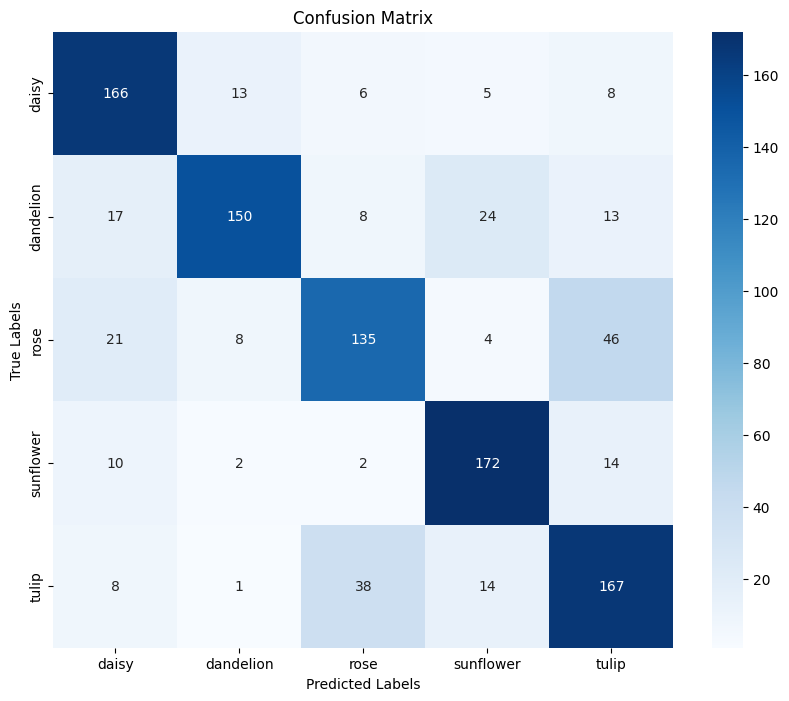

In [ ]:
# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

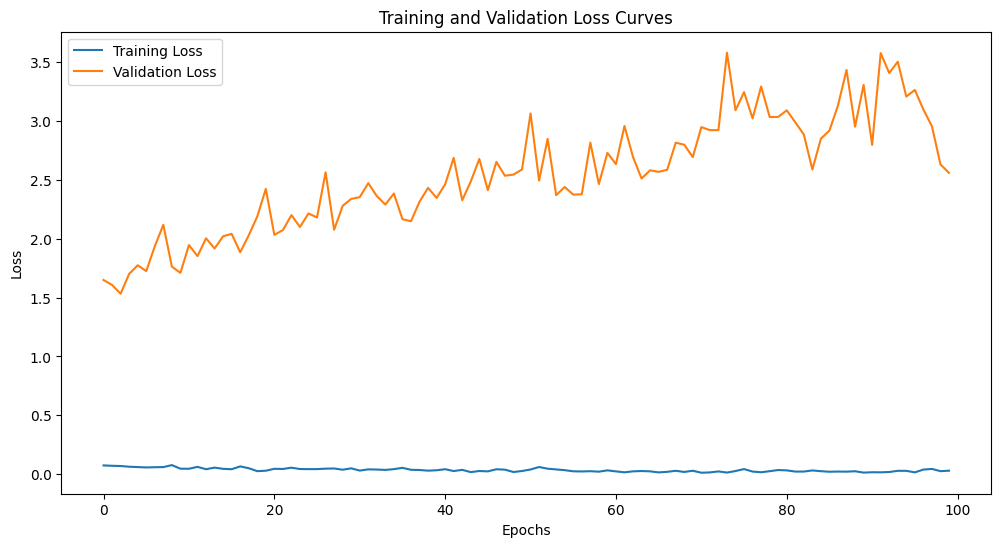

In [ ]:
# Plot training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Measure inference time for a single image
start_time = time.time()
_ = model.predict(X_test[0:1])  # Predict on a single image
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference Time for a Single Image: {inference_time:.4f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Inference Time for a Single Image: 0.0997 seconds


## Support Vector Machine (SVM)

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, learning_curve
import cv2
# SVM requires 2D input (n_samples, n_features)

In [14]:
# Set dataset path
dataset_path = pathlib.Path("./Flower-Classification/flowers")
classes = os.listdir(dataset_path)


In [15]:
def load_images_and_labels(dataset_path, img_size=(128, 128)):
    images = []
    labels = []

    for class_idx, class_name in enumerate(classes):
        class_folder = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img.astype("float32") / 255.0  # Normalize the image
            images.append(img)
            labels.append(class_idx)  # Assign label based on folder index

    return np.array(images), np.array(labels), classes

images, labels, class_names = load_images_and_labels(dataset_path)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

#### Feature Extraction (using HOG)

In [3]:
! pwd

/content


Available species: ['rose', 'daisy', 'dandelion', 'tulip', 'sunflower']


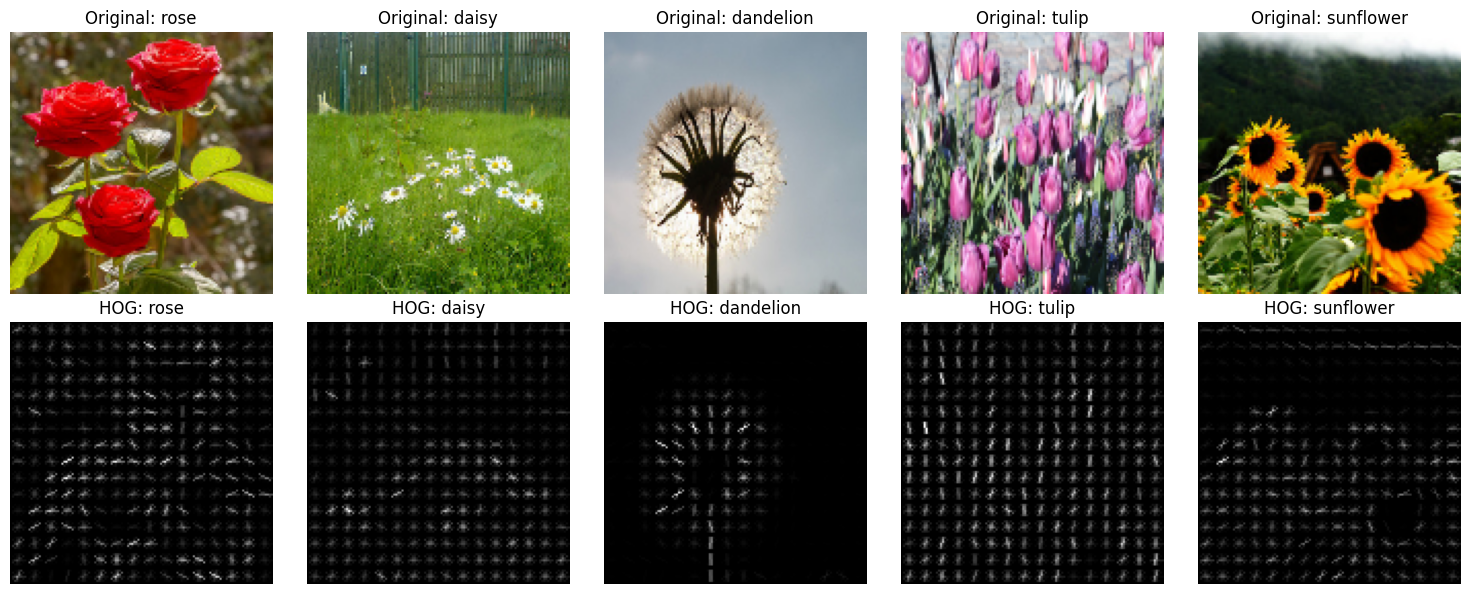

In [15]:
from skimage.feature import hog
from skimage import color

# dataset_path = "/content/Flower-Classification/flowers"

# List all species (subfolders)
species = os.listdir(dataset_path)
print(f"Available species: {species}")

# Initialize containers for original and HOG images
original_images = []
hog_images = []
titles = []

# Process 1 sample from each species
for specie in species:
    specie_folder = os.path.join(dataset_path, specie)
    # Pick a random image from the folder
    image_file = random.choice(os.listdir(specie_folder))
    image_path = os.path.join(specie_folder, image_file)

    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        continue

    # Resize and convert to grayscale
    image_resized = cv2.resize(image, (128, 128))
    gray_image = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

    # Extract HOG features
    hog_features, hog_image = hog(
        gray_image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,
        channel_axis=None,
    )

    # Store results
    original_images.append(image_resized)
    hog_images.append(hog_image)
    titles.append(specie)

# Display results
fig, axes = plt.subplots(2, len(species), figsize=(15, 6))

for i in range(len(species)):
    # Original image
    axes[0, i].imshow(cv2.cvtColor(original_images[i], cv2.COLOR_BGR2RGB))
    axes[0, i].set_title(f"Original: {titles[i]}")
    axes[0, i].axis("off")

    # HOG-transformed image
    axes[1, i].imshow(hog_images[i], cmap="gray")
    axes[1, i].set_title(f"HOG: {titles[i]}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

#### Using Color Histogram

In [16]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Function to extract color histograms
def extract_color_histogram(image, bins=16):
  # Convert to HSV
  image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  # Compute histograms for each channel in HSV
  hist_hue = cv2.calcHist([image_hsv], [0], None, [bins], [0, 256])
  hist_saturation = cv2.calcHist([image_hsv], [1], None, [bins], [0, 256])
  hist_value = cv2.calcHist([image_hsv], [2], None, [bins], [0, 256])

  # Normalize the histograms
  hist_hue /= hist_hue.sum()
  hist_saturation /= hist_saturation.sum()
  hist_value /= hist_value.sum()

  # Concatenate histograms into a single feature vector
  hist = np.concatenate([hist_hue, hist_saturation, hist_value]).flatten()

  return hist_hue, hist_saturation, hist_value

# Load image data (replace with your dataset path)
classes = os.listdir(dataset_path)  # Get flower species folders

# Collect features and labels
features = []
labels = []

for label, flower_class in enumerate(classes):
    flower_folder = os.path.join(dataset_path, flower_class)

    for filename in os.listdir(flower_folder):
        # Load image
        image_path = os.path.join(flower_folder, filename)
        image = cv2.imread(image_path)

        # Extract color histogram features
        hist = extract_color_histogram(image, bins=16)

        # Append to features and labels
        features.append(hist)
        labels.append(label)

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)


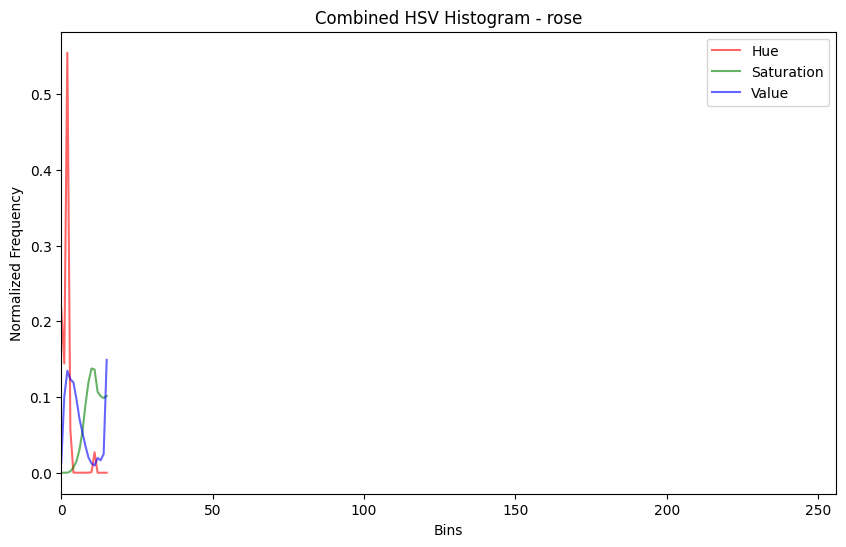

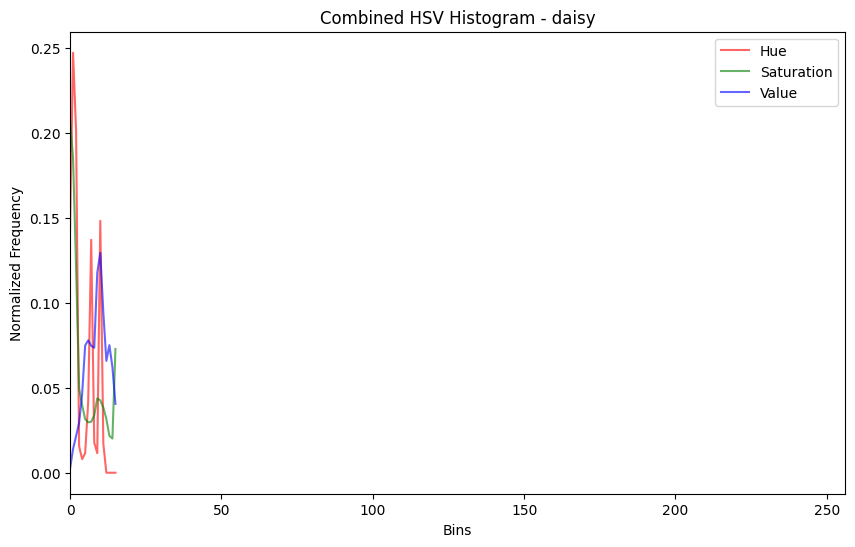

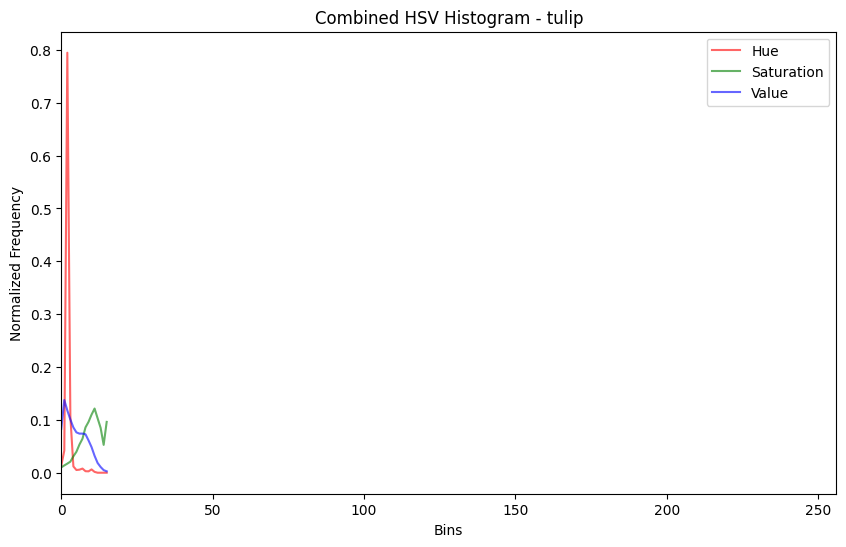

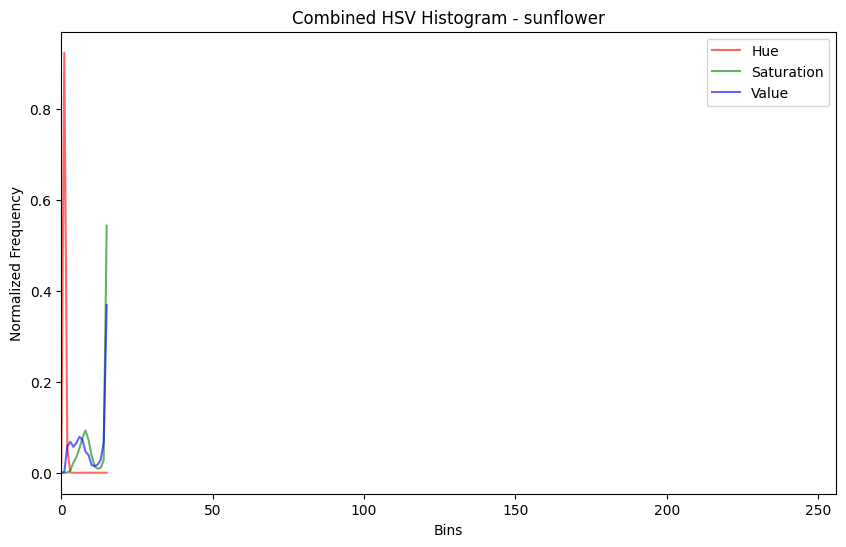

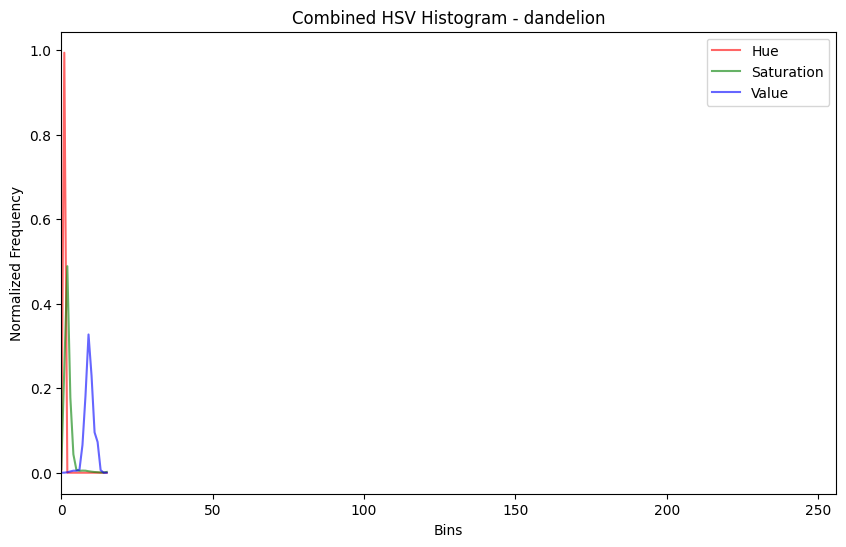

In [17]:
import cv2
import matplotlib.pyplot as plt
import os

# Function to visualize the HSV histogram
def visualize_histogram(image, flower_name):
    # Extract histograms for Hue, Saturation, and Value
    hist_h, hist_s, hist_v = extract_color_histogram(image)

    # Plot combined histogram (Hue + Saturation + Value) in one graph
    plt.figure(figsize=(10, 6))

    plt.plot(hist_h, color='r', label='Hue', alpha=0.6)
    plt.plot(hist_s, color='g', label='Saturation', alpha=0.6)
    plt.plot(hist_v, color='b', label='Value', alpha=0.6)

    plt.title(f"Combined HSV Histogram - {flower_name}")
    plt.xlabel('Bins')
    plt.ylabel('Normalized Frequency')
    plt.legend(loc='upper right')
    plt.xlim([0, 256])

    plt.show()

# Define the path to the 'flowers' directory
flowers_dir = "/content/Flower-Classification/flowers"

# List of flower species
flower_species = ["rose", "daisy", "tulip", "sunflower", "dandelion"]

# Iterate over each flower species
for species in flower_species:
    # Get the first image file for the species (assuming there are images in the folder)
    species_folder = os.path.join(flowers_dir, species)
    image_file = os.listdir(species_folder)[0]  # Take the first image
    image_path = os.path.join(species_folder, image_file)

    # Read the image
    image = cv2.imread(image_path)

    # Visualize the color histogram for the image
    visualize_histogram(image, species)


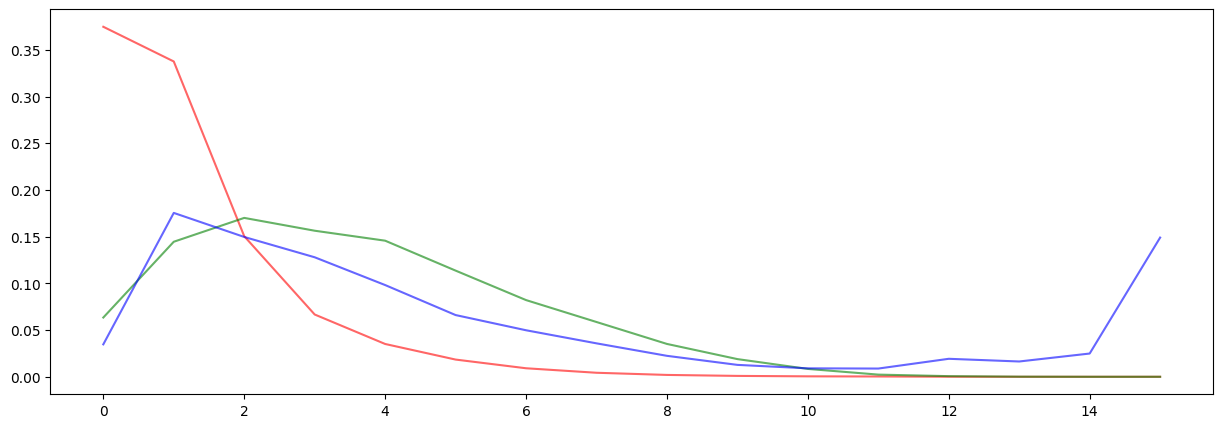

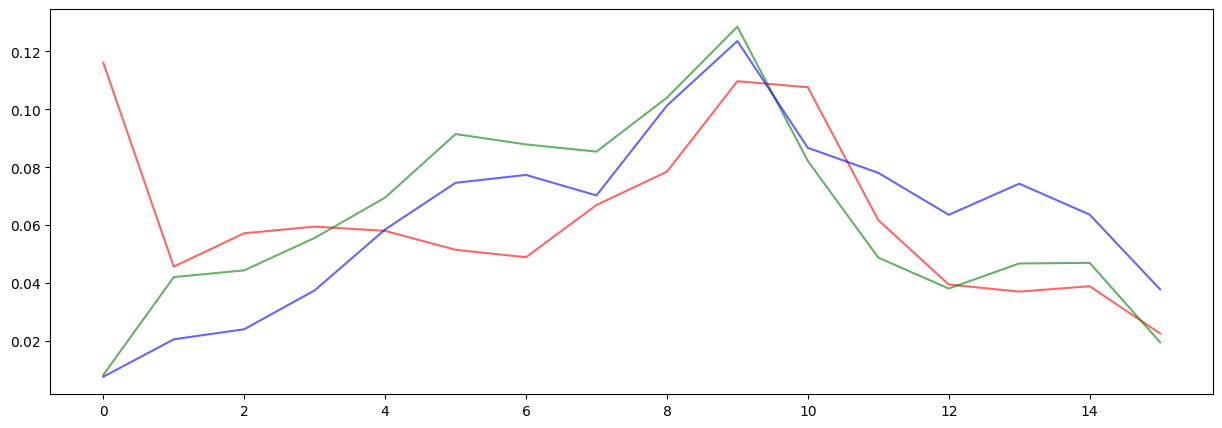

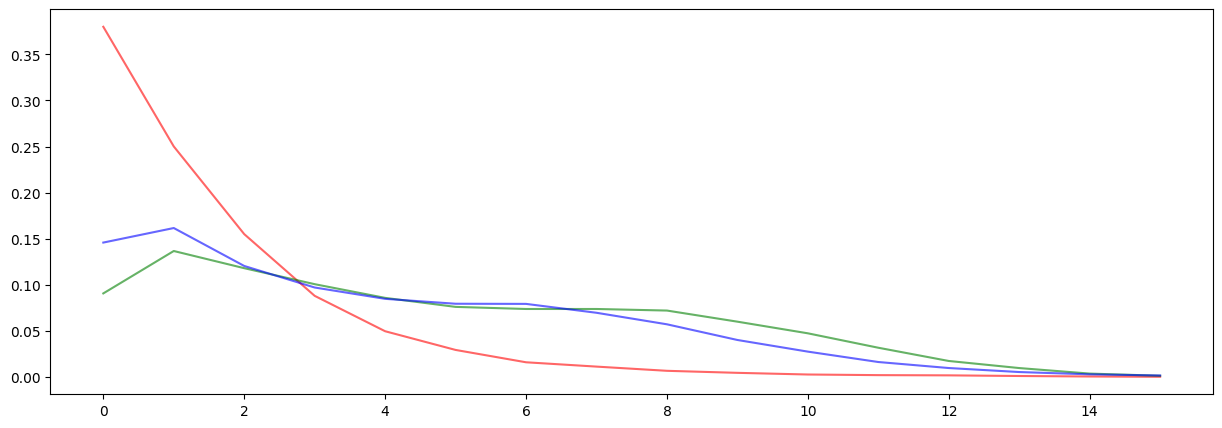

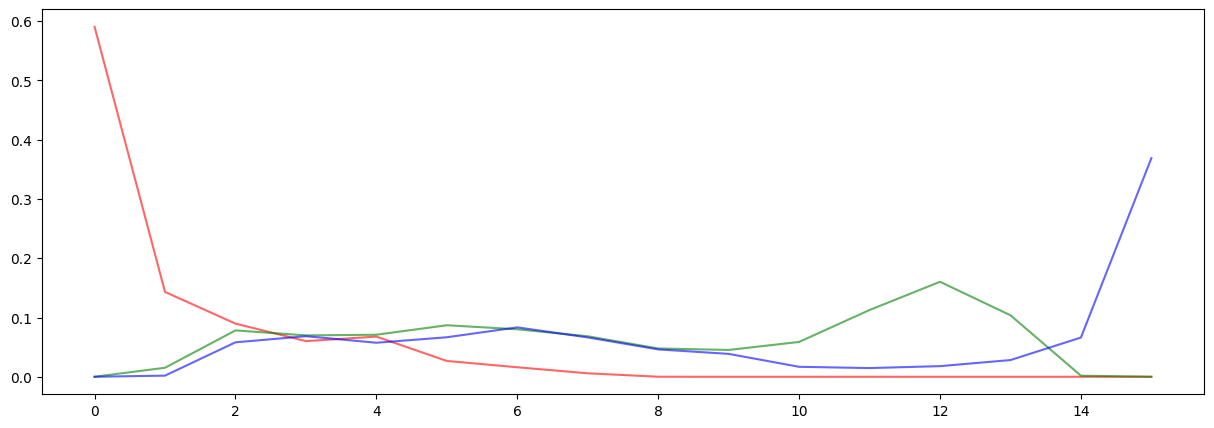

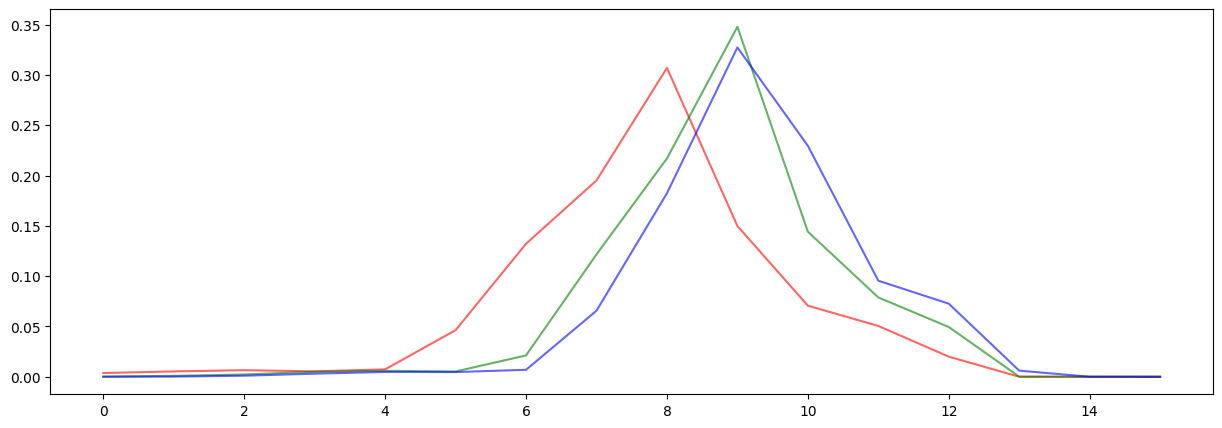

In [18]:
import cv2
import matplotlib.pyplot as plt
import os

# Function to extract RGB histograms
def extract_rgb_histogram(image, bins=16):
    # Split the image into its R, G, B channels
    (r, g, b) = cv2.split(image)

    # Compute the histogram for each channel (Red, Green, Blue)
    hist_r = cv2.calcHist([r], [0], None, [bins], [0, 256])  # Red channel
    hist_g = cv2.calcHist([g], [0], None, [bins], [0, 256])  # Green channel
    hist_b = cv2.calcHist([b], [0], None, [bins], [0, 256])  # Blue channel

    # Normalize the histograms
    hist_r /= hist_r.sum()
    hist_g /= hist_g.sum()
    hist_b /= hist_b.sum()

    # Return the individual histograms (Red, Green, and Blue)
    return hist_r, hist_g, hist_b

# Function to visualize the RGB histogram
def visualize_rgb_histogram(image, flower_name):
    # Extract histograms
    hist_r, hist_g, hist_b = extract_rgb_histogram(image)

    # Plot the histograms for Red, Green, and Blue channels
    plt.figure(figsize=(15, 5))


    plt.plot(hist_r, color='r', label='Hue', alpha=0.6)
    plt.plot(hist_g, color='g', label='Saturation', alpha=0.6)
    plt.plot(hist_b, color='b', label='Value', alpha=0.6)

    # Show the plots
    plt.show()

# Define the path to the 'flowers' directory
flowers_dir = "/content/Flower-Classification/flowers"

# List of flower species
flower_species = ["rose", "daisy", "tulip", "sunflower", "dandelion"]

# Iterate over each flower species
for species in flower_species:
    # Get the first image file for the species (assuming there are images in the folder)
    species_folder = os.path.join(flowers_dir, species)
    image_file = os.listdir(species_folder)[0]  # Take the first image
    image_path = os.path.join(species_folder, image_file)

    # Read the image
    image = cv2.imread(image_path)

    # Visualize the RGB color histogram for the image
    visualize_rgb_histogram(image, species)


## SVM model using RGB histogram

In [20]:
import cv2
import numpy as np
import os
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Function to extract RGB histograms as features
def extract_rgb_histogram(image, bins=16):
    # Split the image into its R, G, B channels
    (r, g, b) = cv2.split(image)

    # Compute the histogram for each channel (Red, Green, Blue)
    hist_r = cv2.calcHist([r], [0], None, [bins], [0, 256])
    hist_g = cv2.calcHist([g], [0], None, [bins], [0, 256])
    hist_b = cv2.calcHist([b], [0], None, [bins], [0, 256])

    # Normalize the histograms
    hist_r /= hist_r.sum()
    hist_g /= hist_g.sum()
    hist_b /= hist_b.sum()

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate([hist_r.flatten(), hist_g.flatten(), hist_b.flatten()])

    return hist_features

# Load the dataset (assuming images are in directories named after the class)
flowers_dir = "/content/Flower-Classification/flowers"
flower_species = ["rose", "daisy", "tulip", "sunflower", "dandelion"]

# Prepare the dataset
features = []
labels = []

for species in flower_species:
    species_folder = os.path.join(flowers_dir, species)
    image_files = os.listdir(species_folder)

    for image_file in image_files:
        # Read the image
        image_path = os.path.join(species_folder, image_file)
        image = cv2.imread(image_path)

        # Resize the image to a consistent size (optional but often useful)
        image = cv2.resize(image, (128, 128))

        # Extract the color histogram as features
        hist_features = extract_rgb_histogram(image)

        # Append the features and the corresponding label (species)
        features.append(hist_features)
        labels.append(species)

# Convert features and labels into numpy arrays
features = np.array(features)
labels = np.array(labels)

# Convert string labels into integers (use label encoding)
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Standardize the features (important for SVM)
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the SVM classifier
svm_model = svm.SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the SVM model with color histograms: {accuracy * 100:.2f}%")


Accuracy of the SVM model with color histograms: 41.51%


#### SVM model using RGB Histogram and HOG (Histogram of Oriented Gradient)

In [22]:
import cv2
import numpy as np
import os
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog
import matplotlib.pyplot as plt

# Function to extract RGB histograms as features
def extract_rgb_histogram(image, bins=16):
    # Split the image into its R, G, B channels
    (r, g, b) = cv2.split(image)

    # Compute the histogram for each channel (Red, Green, Blue)
    hist_r = cv2.calcHist([r], [0], None, [bins], [0, 256])
    hist_g = cv2.calcHist([g], [0], None, [bins], [0, 256])
    hist_b = cv2.calcHist([b], [0], None, [bins], [0, 256])

    # Normalize the histograms
    hist_r /= hist_r.sum()
    hist_g /= hist_g.sum()
    hist_b /= hist_b.sum()

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate([hist_r.flatten(), hist_g.flatten(), hist_b.flatten()])

    return hist_features

# Function to extract HOG features
def extract_hog_features(image, resize_dim=(128, 128)):
    # Resize image to a fixed size for HOG extraction
    image_resized = cv2.resize(image, resize_dim)

    # Convert image to grayscale
    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

    # Extract HOG features
    fd, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # Return the HOG features (fd) flattened
    return fd

# Load the dataset (assuming images are in directories named after the class)
flowers_dir = "/content/Flower-Classification/flowers"
flower_species = ["rose", "daisy", "tulip", "sunflower", "dandelion"]

# Prepare the dataset
features = []
labels = []

for species in flower_species:
    species_folder = os.path.join(flowers_dir, species)
    image_files = os.listdir(species_folder)

    for image_file in image_files:
        # Read the image
        image_path = os.path.join(species_folder, image_file)
        image = cv2.imread(image_path)

        # Resize the image to a consistent size (optional but often useful)
        image = cv2.resize(image, (128, 128))

        # Extract the color histogram as features
        hist_features = extract_rgb_histogram(image)

        # Extract the HOG features
        hog_features = extract_hog_features(image)

        # Combine the RGB histogram and HOG features
        combined_features = np.concatenate([hist_features, hog_features])

        # Append the features and the corresponding label (species)
        features.append(combined_features)
        labels.append(species)

# Convert features and labels into numpy arrays
features = np.array(features)
labels = np.array(labels)

# Convert string labels into integers (use label encoding)
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Standardize the features (important for SVM)
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the SVM classifier
svm_model = svm.SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the SVM model with combined RGB histogram and HOG features: {accuracy * 100:.2f}%")


Accuracy of the SVM model with combined RGB histogram and HOG features: 42.13%


### Transfer Learning as Feature Extractor

We'll use ResNet50, VGG16, and InceptionV3 as feature extractors.

In [1]:
import numpy as np
import os
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader
from PIL import Image
import pathlib


In [3]:
!pwd

/content


In [2]:
## get dataset (using github)

!git clone https://github.com/1211307539/Flower-Classification.git
dataset_path = pathlib.Path("Flower-Classification/flowers")
classes = os.listdir(dataset_path)


Cloning into 'Flower-Classification'...
remote: Enumerating objects: 4330, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 4330 (delta 2), reused 0 (delta 0), pack-reused 4324 (from 2)
Receiving objects: 100% (4330/4330), 227.26 MiB | 56.64 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
# Set dataset path
dataset_path = pathlib.Path("./Flower-Classification/flowers")
classes = os.listdir(dataset_path)


In [29]:
import os
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image
import torch

IMG_SIZE = 224

# Define the transformation to match what VGG16 and VGG19 expect
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ImageNet pre-trained models
])

def load_images(dataset_path, img_size=IMG_SIZE):
    images = []
    labels = []
    for label, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

            img_pil = Image.fromarray(img_rgb) # convert to PIL image
            img_tensor = transform(img_pil)

            images.append(img_tensor)
            labels.append(label)

    return torch.stack(images), np.array(labels)  # Use torch.stack for batches of images

# Load images and labels
X, y = load_images(dataset_path)


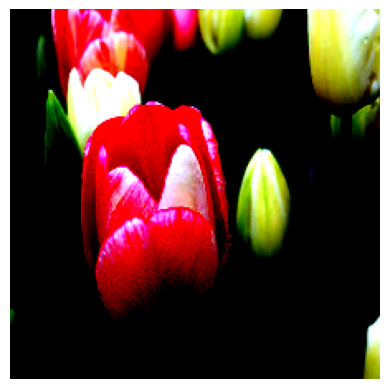

In [32]:
# Function to show an image
def show_image(image_tensor):
    # Convert the image from tensor to NumPy array
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert to HWC format
    image = np.clip(image, 0, 1)  # Ensure pixel values are in the [0, 1] range

    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Hide axis
    plt.show()

# Show a sample image from the loaded dataset
sample_image_tensor = X[100]
show_image(sample_image_tensor)

# The image may look muddy especially after certain transformations (like normalization)
# are applied. This is ok because
# when training the model, the model learns from the numerical representations of the image,
# not necessarily from the image's visual appearance.

In [ ]:
import os
import cv2
import numpy as np
from torchvision import transforms, models
from PIL import Image
import torch
import joblib
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
# Load Pre-trained Models
resnet50_model = models.resnet50(pretrained=True)
vgg16_model = models.vgg16(pretrained=True)
vgg19_model = models.vgg19(pretrained=True)

# Remove fully connected layers to use the feature extraction part
resnet50_model = torch.nn.Sequential(*list(resnet50_model.children())[:-1])
vgg16_model = torch.nn.Sequential(*list(vgg16_model.children())[:-1])
vgg19_model = torch.nn.Sequential(*list(vgg19_model.children())[:-1])

# Set models to evaluation mode
resnet50_model.eval()
vgg16_model.eval()
vgg19_model.eval()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ImageNet pre-trained models
])

# Function to extract features from models
def extract_features(model, image):
    image = transform(image)  # Apply the transformations (resize, normalize)
    image = image.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():  # Disable gradient calculation for inference
        features = model(image)
    features = features.squeeze().cpu().numpy()  # Remove batch dimension and convert to numpy
    return features

In [ ]:
def load_images(dataset_path, img_size=IMG_SIZE):
    images_resnet, images_vgg16, images_vgg19 = [], [], []
    labels = []
    for label, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

            img_pil = Image.fromarray(img_rgb) # convert to PIL image

            # Extract features using all models
            resnet_feat = extract_features(resnet50_model, img_pil)
            vgg16_feat = extract_features(vgg16_model, img_pil)
            vgg19_feat = extract_features(vgg19_model, img_pil)

            # Append features and label to their respective lists
            images_resnet.append(resnet_feat)
            images_vgg16.append(vgg16_feat)
            images_vgg19.append(vgg19_feat)
            labels.append(label)

    return np.array(images_resnet), np.array(images_vgg16), np.array(images_vgg19), np.array(labels)


In [ ]:
# Load images and labels
X_resnet, X_vgg16, X_vgg19, y = load_images(dataset_path)

In [ ]:
X_resnet_train, X_resnet_test, y_train, y_test = train_test_split(X_resnet, y, test_size=0.2, random_state=42)
X_vgg16_train, X_vgg16_test = train_test_split(X_vgg16, test_size=0.2, random_state=42)
X_vgg19_train, X_vgg19_test = train_test_split(X_vgg19, test_size=0.2, random_state=42)


In [ ]:
svm_resnet = SVC(kernel="linear", C=1, random_state=42)
svm_vgg16 = SVC(kernel="linear", C=1, random_state=42)
svm_vgg19 = SVC(kernel="linear", C=1, random_state=42)

In [ ]:
# Train the SVM classifier for ResNet50 features
svm_resnet.fit(X_resnet_train, y_train)

# Train the SVM classifier for VGG16 features
svm_vgg16.fit(X_vgg16_train, y_train)

# Train the SVM classifier for VGG19 features
svm_vgg19.fit(X_vgg19_train, y_train)

In [ ]:
# Predict using the SVM classifier
y_pred_resnet = svm_resnet.predict(X_resnet_test)
y_pred_vgg16 = svm_vgg16.predict(X_vgg16_test)
y_pred_vgg19 = svm_vgg19.predict(X_vgg19_test)

# Calculate and print accuracy for each model
accuracy_resnet = accuracy_score(y_test, y_pred_resnet)
accuracy_vgg16 = accuracy_score(y_test, y_pred_vgg16)
accuracy_vgg19 = accuracy_score(y_test, y_pred_vgg19)

In [ ]:
print(f"Accuracy for ResNet50: {accuracy_resnet:.2f}")
print(f"Accuracy for VGG16: {accuracy_vgg16:.2f}")
print(f"Accuracy for VGG19: {accuracy_vgg19:.2f}")

# Print classification report for each model
print("\nClassification Report for ResNet50:")
print(classification_report(y_test, y_pred_resnet))

print("\nClassification Report for VGG16:")
print(classification_report(y_test, y_pred_vgg16))

print("\nClassification Report for VGG19:")
print(classification_report(y_test, y_pred_vgg19))

In [ ]:
joblib.dump(svm_resnet, "svm_resnet_model.joblib")
joblib.dump(svm_vgg16, "svm_vgg16_model.joblib")
joblib.dump(svm_vgg19, "svm_vgg19_model.joblib")

# remove

In [33]:
from torchvision.models import ResNet50_Weights, VGG16_Weights, VGG19_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained models for feature extraction
def get_resnet_model():
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the final classification layer
    return model.to(device).eval()

def get_vgg16_model():
    model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    model = torch.nn.Sequential(*list(model.features))  # Use only the feature extraction part
    return model.to(device).eval()

def get_vgg19_model():
    model = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
    model = torch.nn.Sequential(*list(model.features))  # Use only the feature extraction part
    return model.to(device).eval()

# Initialize models
resnet_model = get_resnet_model()
vgg16_model = get_vgg16_model()
vgg19_model = get_vgg19_model()

# Define a transform for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

# Feature extraction function
def extract_features(model, image):
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():  # Disable gradient calculation
        features = model(image)
    return features.cpu().squeeze().numpy()  # Return features as NumPy array




In [34]:
image_path = "/content/Flower-Classification/flowers/rose/12240303_80d87f77a3_n.jpg"

# Extract features as sample
resnet_features = extract_features(resnet_model, image)

print(resnet_features)

[0.31326547 0.32062107 0.9051684  ... 0.6876803  0.94747627 0.32887164]


In [ ]:
# Extract features and labels
features_resnet, features_vgg16, features_vgg19, labels = [], [], [], []

for label, flower_class in enumerate(classes):
    flower_folder = os.path.join(dataset_path, flower_class)
    for filename in os.listdir(flower_folder):
        image_path = os.path.join(flower_folder, filename)
        image = cv2.imread(image_path)
        image_pil = Image.open(image_path)

        # Extract features
        resnet_feat = extract_features(resnet_model, image_pil)
        vgg16_feat = extract_features(vgg16_model, image_pil)
        vgg19_feat = extract_features(vgg19_model, image_pil)

        # Append features and label
        features_resnet.append(resnet_feat)
        features_vgg16.append(vgg16_feat)
        features_vgg19.append(vgg19_feat)
        labels.append(label)

# Convert to numpy arrays
features_resnet = np.array(features_resnet)
features_vgg16 = np.array(features_vgg16)
features_vgg19 = np.array(features_vgg19)
labels = np.array(labels)


In [11]:
print(features_resnet.shape)
print(features_vgg16.shape)
print(features_vgg19.shape)
print(labels.shape)


(4317, 3, 16, 1)
(4317, 2048)
(4317, 512, 7, 7)
(4317, 512, 7, 7)
(4317,)


In [6]:
# Flatten features
features_vgg16 = features_vgg16.reshape(features_vgg16.shape[0], -1)  # Flatten to (4317, 25088)
features_vgg19 = features_vgg19.reshape(features_vgg19.shape[0], -1)  # Flatten to (4317, 25088)


In [7]:
# Split data into train and test sets
X_train_resnet, X_test_resnet, y_train_resnet, y_test_resnet = train_test_split(features_resnet, labels, test_size=0.2, random_state=42)
X_train_vgg16, X_test_vgg16, y_train_vgg16, y_test_vgg16 = train_test_split(features_vgg16, labels, test_size=0.2, random_state=42)
X_train_vgg19, X_test_vgg19, y_train_vgg19, y_test_vgg19 = train_test_split(features_vgg19, labels, test_size=0.2, random_state=42)


In [14]:
print(X_train_resnet.shape, X_test_resnet.shape)
print(X_train_vgg16.shape, X_test_vgg16.shape)
print(X_train_vgg19.shape, X_test_vgg19.shape)


(3453, 48) (864, 48) (3453,) (864,)
(3453, 2048) (864, 2048)
(3453, 25088) (864, 25088)
(3453, 25088) (864, 25088)


In [8]:
models = [
    ("ResNet50", X_train_resnet, X_test_resnet, y_train_resnet, y_test_resnet),
    ("VGG16", X_train_vgg16, X_test_vgg16, y_train_vgg16, y_test_vgg16),
    ("VGG19", X_train_vgg19, X_test_vgg19, y_train_vgg19, y_test_vgg19),
]

In [10]:
import joblib

# Train and evaluate SVM models for each dataset
for model_name, X_train, X_test, y_train, y_test in models:
    clf = SVC(kernel="linear", C=1, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Calculate and print accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {model_name}: {accuracy:.2f}\n")

    # Print classification report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))

    # Save the trained model
    model_filename = f"{model_name}_svm_model.joblib"
    joblib.dump(clf, model_filename)


Accuracy for ResNet50: 0.88

Classification Report for ResNet50:

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       165
           1       0.87      0.87      0.87       165
           2       0.89      0.89      0.89       210
           3       0.88      0.88      0.88       178
           4       0.89      0.88      0.89       146

    accuracy                           0.88       864
   macro avg       0.88      0.88      0.88       864
weighted avg       0.88      0.88      0.88       864

Accuracy for VGG16: 0.87

Classification Report for VGG16:

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       165
           1       0.92      0.81      0.86       165
           2       0.88      0.92      0.90       210
           3       0.83      0.88      0.85       178
           4       0.92      0.84      0.88       146

    accuracy                           0.87       864
   ma

#### Visualizing Hyperplane to Observe the Decision Boundary of ResNet50-SVM Model

Since this dataset is highly dimensional (image features), visualizing the hyperplane may not be feasible. However, we can see how SVM separates out data in 2D or 3D space using dimensionality reduction techniques like Principal Component Analysis (PCA).

Note: This keeps crashing the session :(
  

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
pca = PCA(n_components=2)

# Apply PCA only to the training data first, then transform the test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resnet)
X_test_scaled = scaler.transform(X_test_resnet)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train the SVM with a linear kernel on the reduced feature space
svm_pca = SVC(kernel='linear')
svm_pca.fit(X_train_pca, y_train)

# Get the hyperplane (coefficients of the linear kernel)
coef = svm_pca.coef_
intercept = svm_pca.intercept_

# Create a mesh grid to plot the decision boundary
h = .02  # Step size for mesh grid
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Compute decision function values for the mesh grid
Z = svm_pca.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


In [ ]:
# Plot the decision boundary and margin
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.2, colors=['r', 'g', 'b'])
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', edgecolors='k', marker='o')
plt.title('ResNet50-SVM Hyperplane Visualization with PCA-reduced Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

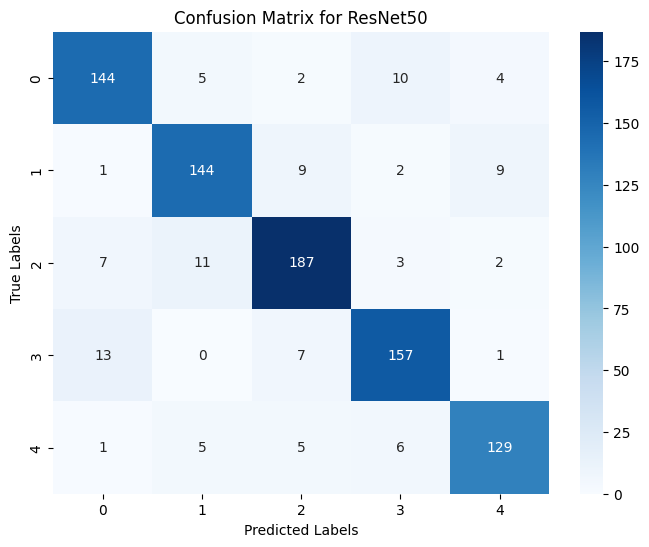

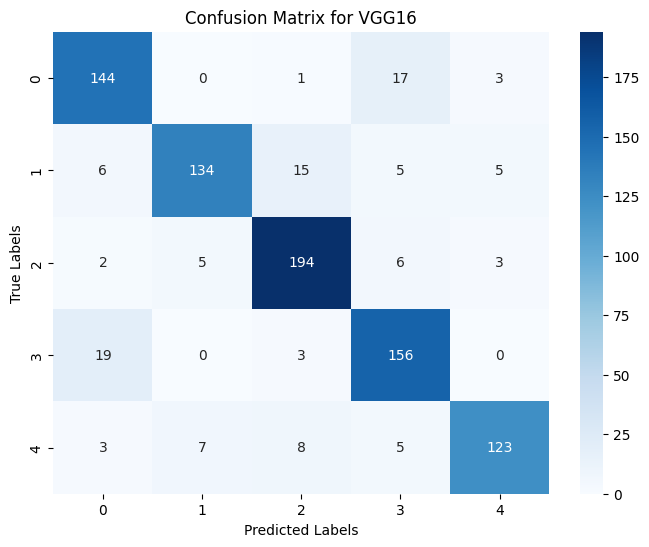

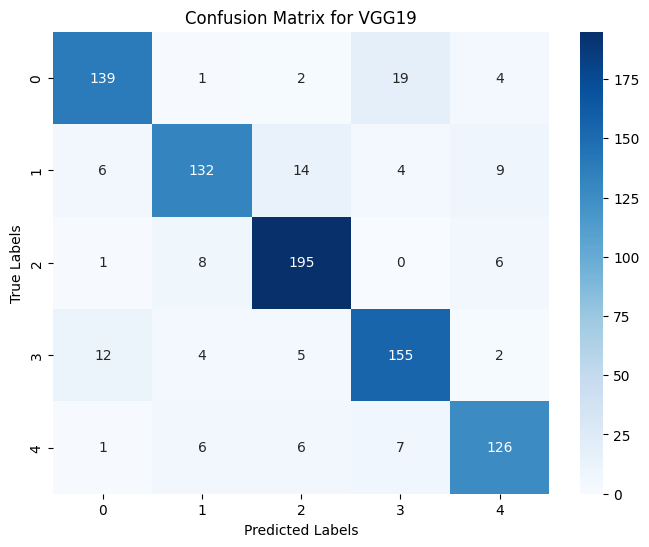

In [12]:
# Loop over each model
for model_name, X_train, X_test, y_train, y_test in models:
    X_train = X_train.reshape(X_train.shape[0], -1)  # Reshaping to (n_samples, n_features)
    X_test = X_test.reshape(X_test.shape[0], -1)
    # Train the SVM classifier
    clf = SVC(kernel="linear", C=1, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
